In [1]:
# US Crime Dataset - Advanced Analysis
## Model: MLP Classifier (Neural Network)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Sklearn Araçları
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Sinir Ağları için Özellik Çıkarımı (PCA)
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance # Önem hesabı için şart
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, f1_score

warnings.filterwarnings('ignore')
print(">>> Gerekli kütüphaneler yüklendi.")

>>> Gerekli kütüphaneler yüklendi.


In [17]:
# Dosya Yolu
FILE_PATH = 'US_Crime_DataSet.csv'

def load_data(path):
    print(f"📂 Dosya okunuyor: {path}...")
    try:
        df = pd.read_csv(path, low_memory=False)
        print(f"✅ Veri Seti Yüklendi. Boyut: {df.shape}")
        return df
    except FileNotFoundError:
        print("❌ HATA: Dosya bulunamadı!")
        return None

df = load_data(FILE_PATH)
if df is not None:
    display(df.head())

📂 Dosya okunuyor: US_Crime_DataSet.csv...
✅ Veri Seti Yüklendi. Boyut: (638454, 24)


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [18]:
def clean_data(df):
    print(">>> 1. Aşama: Veri Temizliği Başlıyor...")
    
    # Gereksiz Sütunlar
    drop_cols = ['Record ID', 'Agency Code', 'Incident', 'Record Source',
                 'Victim Ethnicity', 'Victim Count', 'Perpetrator Ethnicity', 'Perpetrator Count',
                 'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship']
    
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # --- KRİTİK DÜZELTME BURADA ---
    # Hedef Değişken (Yes/No -> 1/0)
    if 'Crime Solved' in df.columns:
        # Önce eşle
        df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})
        
        # Eşleşmeyen (NaN olan) var mı bak?
        nan_count = df['Crime Solved'].isna().sum()
        if nan_count > 0:
            print(f"⚠️ UYARI: Hedef değişkende {nan_count} adet tanımlanamayan (NaN) veri bulundu.")
            print("   -> Bu satırlar eğitimden çıkarılıyor...")
            # NaN olan satırları sil
            df = df.dropna(subset=['Crime Solved'])
            
        # Garanti olsun diye int tipine çevir
        df['Crime Solved'] = df['Crime Solved'].astype(int)
    
    # Yaş Sütunu Düzenleme
    df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce').fillna(30)
    
    print(f"✅ Temizlik Tamamlandı. Güncel Veri Sayısı: {len(df)}")
    return df

if df is not None:
    df = clean_data(df)

>>> 1. Aşama: Veri Temizliği Başlıyor...
✅ Temizlik Tamamlandı. Güncel Veri Sayısı: 638454


In [19]:
def apply_feature_engineering(df):
    print(">>> 2. Aşama: Feature Engineering (Yeni Özellik Türetme)...")
    
    # 1. MEVSİM (SEASON)
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'
    df['Season'] = df['Month'].apply(get_season)
    print(f"- 'Season' özelliği oluşturuldu.")

    # 2. YAŞ GRUBU (AGE GROUP)
    bins = [0, 18, 29, 59, 120]
    labels = ['Child', 'Young_Adult', 'Adult', 'Senior']
    df['Age_Group'] = pd.cut(df['Victim Age'], bins=bins, labels=labels, right=True).astype(object).fillna('Unknown')
    print(f"- 'Age_Group' özelliği oluşturuldu.")

    # 3. BÖLGE (REGION)
    regions = {
        'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'AZ', 'NM', 'CO', 'AK', 'HI'],
        'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
        'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DE', 'MD', 'DC'],
        'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
    }
    state_to_region = {state: region for region, states in regions.items() for state in states}
    df['Region'] = df['State'].map(state_to_region).fillna('Other')
    print(f"- 'Region' özelliği oluşturuldu.")
    
    return df

if df is not None:
    df = apply_feature_engineering(df)
    display(df[['Season', 'Age_Group', 'Region']].head())

>>> 2. Aşama: Feature Engineering (Yeni Özellik Türetme)...
- 'Season' özelliği oluşturuldu.
- 'Age_Group' özelliği oluşturuldu.
- 'Region' özelliği oluşturuldu.


,Season,Age_Group,Region
0,Fall,Child,Other
1,Fall,Adult,Other
2,Fall,Adult,Other
3,Fall,Adult,Other
4,Fall,Adult,Other


In [20]:
def apply_encoding(df):
    print(">>> 3. Aşama: Encoding (Kategorik -> Sayısal)...")
    
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Unknown')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
    print("✅ Kategorik veriler sayıya çevrildi.")
    return df

if df is not None:
    df_processed = apply_encoding(df)

>>> 3. Aşama: Encoding (Kategorik -> Sayısal)...
✅ Kategorik veriler sayıya çevrildi.


In [21]:
if df is not None:
    X = df_processed.drop('Crime Solved', axis=1)
    y = df_processed['Crime Solved']
    
    # MLP için Scaling ZORUNLUDUR
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    print(f"Veri Hazır! Eğitim Seti: {X_train_raw.shape}")

Veri Hazır! Eğitim Seti: (510763, 14)


In [22]:
def apply_pca(X_train, X_test):
    print(">>> PCA (Principal Component Analysis) Uygulanıyor...")
    
    # Veriyi 10 ana bileşene indir
    pca = PCA(n_components=10, random_state=42)
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Bileşen isimleri oluşturalım (PC1, PC2...)
    pca_feature_names = [f"PC_{i+1}" for i in range(10)]
    
    print(f"✅ Boyut İndirgeme Tamamlandı: {X_train.shape[1]} -> {X_train_pca.shape[1]}")
    print(f"ℹ️  Korunan Bilgi Oranı: %{sum(pca.explained_variance_ratio_)*100:.2f}")
    
    return X_train_pca, X_test_pca, pca_feature_names

X_train, X_test, final_feature_names = apply_pca(X_train_raw, X_test_raw)

>>> PCA (Principal Component Analysis) Uygulanıyor...
✅ Boyut İndirgeme Tamamlandı: 14 -> 10
ℹ️  Korunan Bilgi Oranı: %88.71


In [23]:
print("🧠 MLPClassifier (Yapay Sinir Ağı) Eğitiliyor...")
print("(Bu işlem işlemci gücüne göre biraz zaman alabilir...)")
start_time = time.time()

# 2 Gizli Katman (50 nöron, 30 nöron)
# early_stopping=True: Gereksiz yere uzatmayı önler.
model = MLPClassifier(
    hidden_layer_sizes=(50, 30), 
    max_iter=100, 
    activation='relu', 
    solver='adam', 
    random_state=42, 
    early_stopping=True
)

model.fit(X_train, y_train)

elapsed = time.time() - start_time
print(f"✅ Eğitim Bitti! Süre: {elapsed:.2f} saniye")

🧠 MLPClassifier (Yapay Sinir Ağı) Eğitiliyor...
(Bu işlem işlemci gücüne göre biraz zaman alabilir...)
✅ Eğitim Bitti! Süre: 160.13 saniye


In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc = roc_auc_score(y_test, y_prob)

print("="*60)
print(f"SONUÇ: Accuracy: %{acc*100:.2f} | ROC AUC: {roc:.4f}")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Çözülemedi', 'Çözüldü']))

SONUÇ: Accuracy: %72.57 | ROC AUC: 0.7122
              precision    recall  f1-score   support

  Çözülemedi       0.59      0.24      0.35     37875
     Çözüldü       0.74      0.93      0.83     89816

    accuracy                           0.73    127691
   macro avg       0.67      0.59      0.59    127691
weighted avg       0.70      0.73      0.68    127691



In [25]:
def show_feature_importance_table(model, X_test, y_test, feature_names):
    print(">>> PCA Bileşenlerinin önemi hesaplanıyor...")
    # Permutation Importance ile hangi PC'nin önemli olduğunu bul
    result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    importances = result.importances_mean
    
    feature_imp_df = pd.DataFrame({
        'Bileşen (Component)': feature_names,
        'Önem Puanı': importances
    }).sort_values(by='Önem Puanı', ascending=False)
    
    feature_imp_df['Katkı (%)'] = (feature_imp_df['Önem Puanı'] * 100).map('{:.2f}%'.format)
    
    print("\n📊 ÖZELLİK (BİLEŞEN) ÖNEM TABLOSU")
    display(feature_imp_df)
    return importances

final_importances = show_feature_importance_table(model, X_test, y_test, final_feature_names)

>>> PCA Bileşenlerinin önemi hesaplanıyor...

📊 ÖZELLİK (BİLEŞEN) ÖNEM TABLOSU


,Bileşen (Component),Önem Puanı,Katkı (%)
8,PC_9,0.059467,5.95%
3,PC_4,0.040849,4.08%
2,PC_3,0.040545,4.05%
5,PC_6,0.030611,3.06%
1,PC_2,0.030012,3.00%
0,PC_1,0.028807,2.88%
4,PC_5,0.023753,2.38%
7,PC_8,0.017383,1.74%
6,PC_7,0.015796,1.58%
9,PC_10,0.013832,1.38%


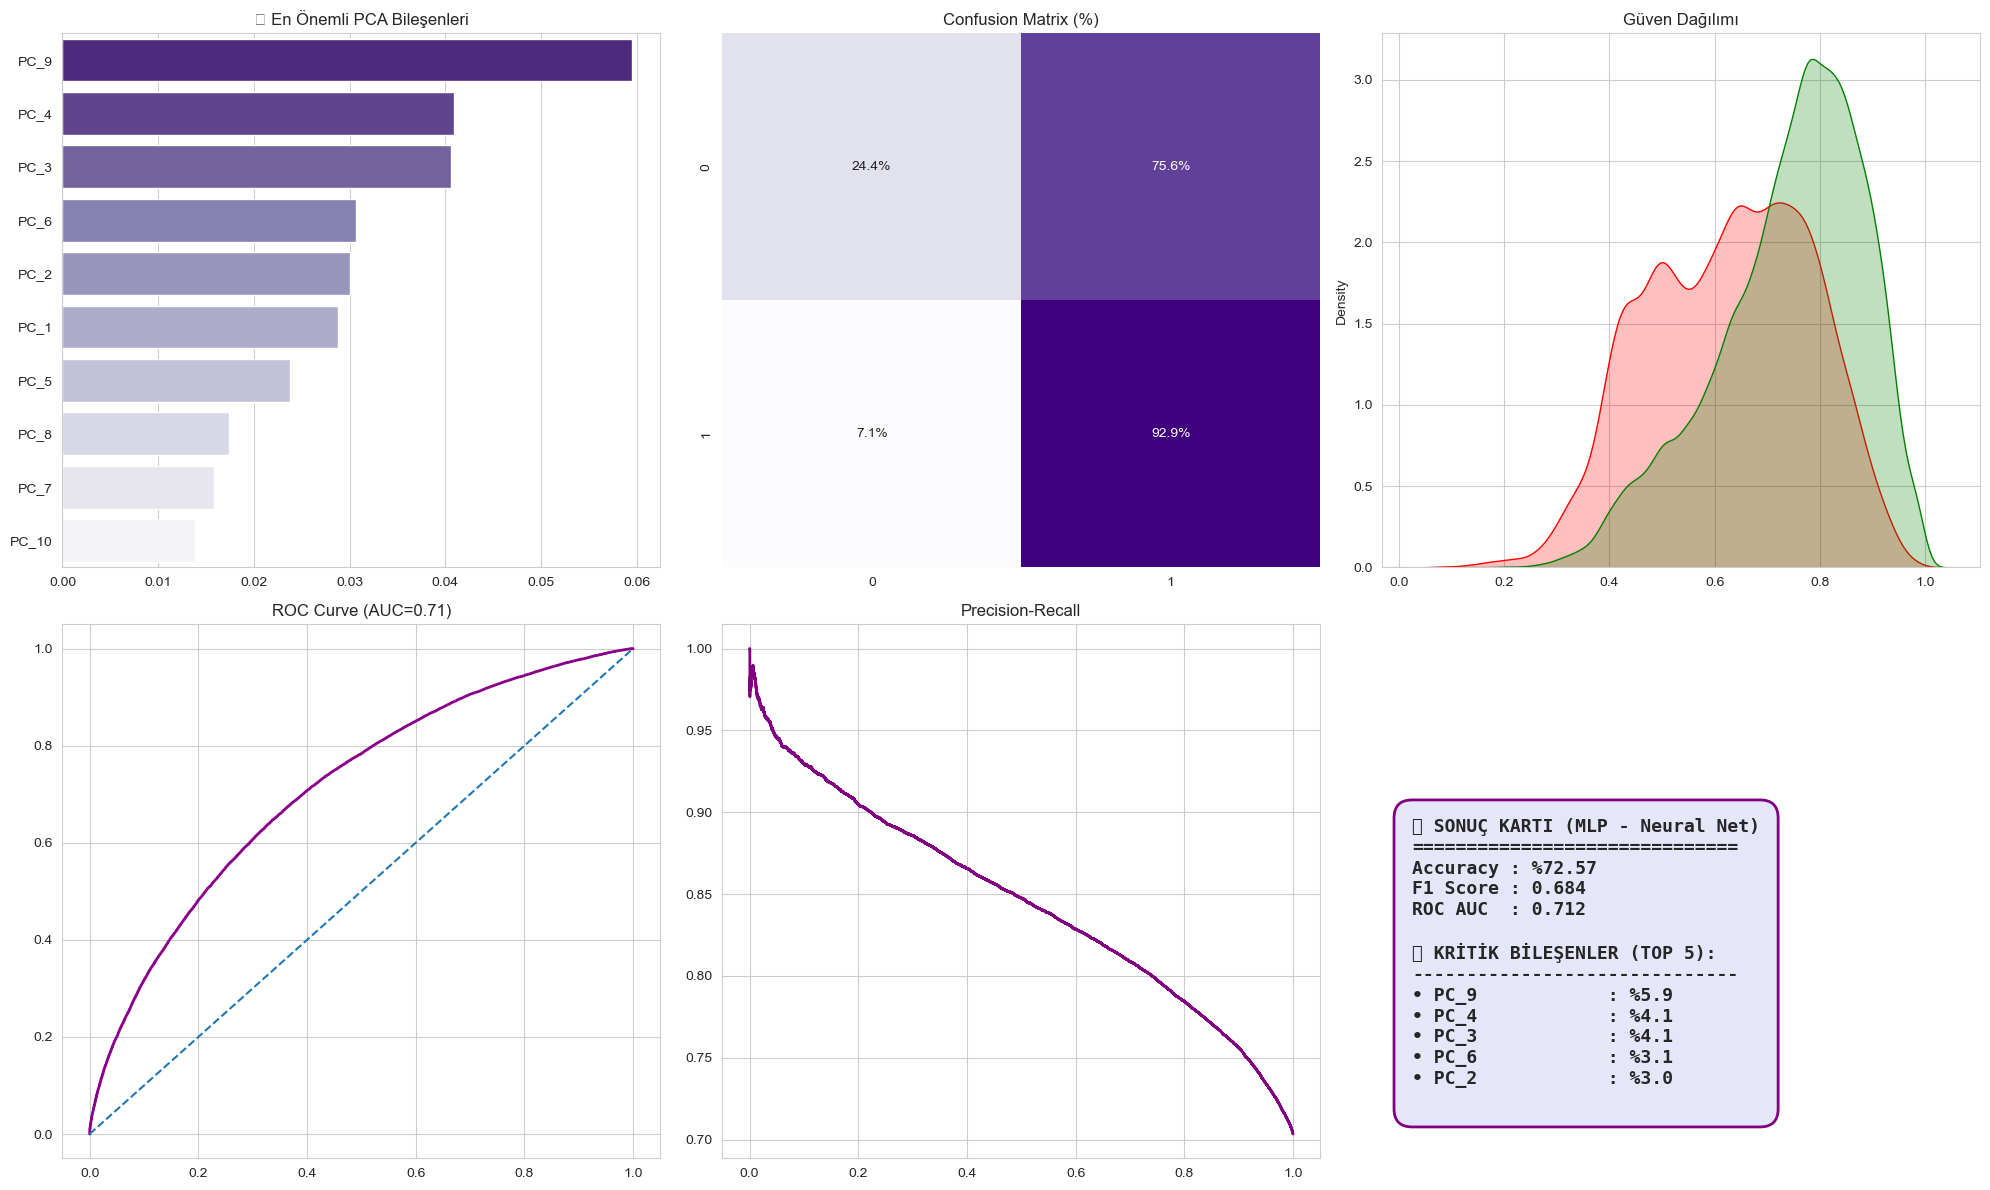

In [26]:
def plot_dashboard(model, X_test, y_test, feature_names, y_pred, y_prob, importances=None):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3)

    # 1. Feature Importance (PCA Bileşenleri)
    ax1 = fig.add_subplot(gs[0, 0])
    if importances is not None:
        idx = np.argsort(importances)[::-1][:10]
        # Mor Palet (Purples_r)
        sns.barplot(x=importances[idx], y=[feature_names[i] for i in idx], palette="Purples_r", ax=ax1)
        ax1.set_title('🔍 En Önemli PCA Bileşenleri')
    else:
        ax1.text(0.5, 0.5, "Hesaplanamadı", ha='center')

    # 2. Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Purples', cbar=False, ax=ax2)
    ax2.set_title('Confusion Matrix (%)')

    # 3. Güven Dağılımı
    ax3 = fig.add_subplot(gs[0, 2])
    sns.kdeplot(y_prob[y_test==0], shade=True, color='red', label='Çözülemedi', ax=ax3)
    sns.kdeplot(y_prob[y_test==1], shade=True, color='green', label='Çözüldü', ax=ax3)
    ax3.set_title('Güven Dağılımı')

    # 4. ROC
    ax4 = fig.add_subplot(gs[1, 0])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax4.plot(fpr, tpr, color='darkmagenta', lw=2)
    ax4.plot([0, 1], [0, 1], linestyle='--')
    ax4.set_title(f'ROC Curve (AUC={roc_auc_score(y_test, y_prob):.2f})')

    # 5. Precision-Recall
    ax5 = fig.add_subplot(gs[1, 1])
    p, r, _ = precision_recall_curve(y_test, y_prob)
    ax5.plot(r, p, color='purple', lw=2)
    ax5.set_title('Precision-Recall')

    # 6. SONUÇ KARTI
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_prob)
    
    # En İyi 5 Bileşen
    feature_text = ""
    if importances is not None:
        idx = np.argsort(importances)[::-1][:5]
        feature_text += "\n📌 KRİTİK BİLEŞENLER (TOP 5):\n"
        feature_text += "-"*30 + "\n"
        for i in idx:
            feature_text += f"• {feature_names[i]:<15} : %{importances[i]*100:.1f}\n"
    
    txt = f"🏁 SONUÇ KARTI (MLP - Neural Net)\n" \
          f"==============================\n" \
          f"Accuracy : %{acc*100:.2f}\n" \
          f"F1 Score : {f1:.3f}\n" \
          f"ROC AUC  : {roc:.3f}\n" \
          f"{feature_text}"
    
    # Mor Arkaplan (Lavender)
    ax6.text(0.05, 0.1, txt, fontsize=13, family='monospace', weight='bold', 
             bbox=dict(facecolor='lavender', alpha=1, boxstyle='round,pad=1', edgecolor='purple', linewidth=2))

    plt.tight_layout()
    plt.show()

plot_dashboard(model, X_test, y_test, final_feature_names, y_pred, y_prob, final_importances)